In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
url = '/content/drive/MyDrive/Quantile based optimization/DataPrepFinal.csv'

In [ ]:
df = pd.read_csv(url)

In [ ]:
df.head()

,Unnamed: 0,Timestamp,open,high,low,close,volume,RSI,MOM,TR,ATR,SAR,Returns
0,0,21-12-2020 12:35,2009.65,2010.00,2004.50,2007.90,173550.0,NaN,NaN,NaN,NaN,NaN,0.000000
1,1,21-12-2020 12:40,2007.90,2009.00,2005.80,2006.70,87120.0,NaN,NaN,3.20,NaN,2004.50,-0.000598
2,2,21-12-2020 12:45,2005.65,2007.80,2003.15,2007.05,117939.0,NaN,NaN,4.65,NaN,2009.00,0.000174
3,3,21-12-2020 12:50,2007.45,2008.95,2006.95,2007.90,76782.0,NaN,NaN,2.00,NaN,2009.00,0.000424
4,4,21-12-2020 12:55,2008.00,2008.00,2001.60,2002.40,154965.0,NaN,NaN,6.40,NaN,2008.95,-0.002739


In [ ]:
df['Returns'].max()

0.021452667088340812

In [ ]:
df['sign'] = df['Returns'].apply(lambda x : 2.5 if x>0 else -2.5)

In [ ]:
df['Returns_100'] = 100 * df['Returns']

In [ ]:
df.sign.value_counts()

-2.5    2738
 2.5    2243
Name: sign, dtype: int64

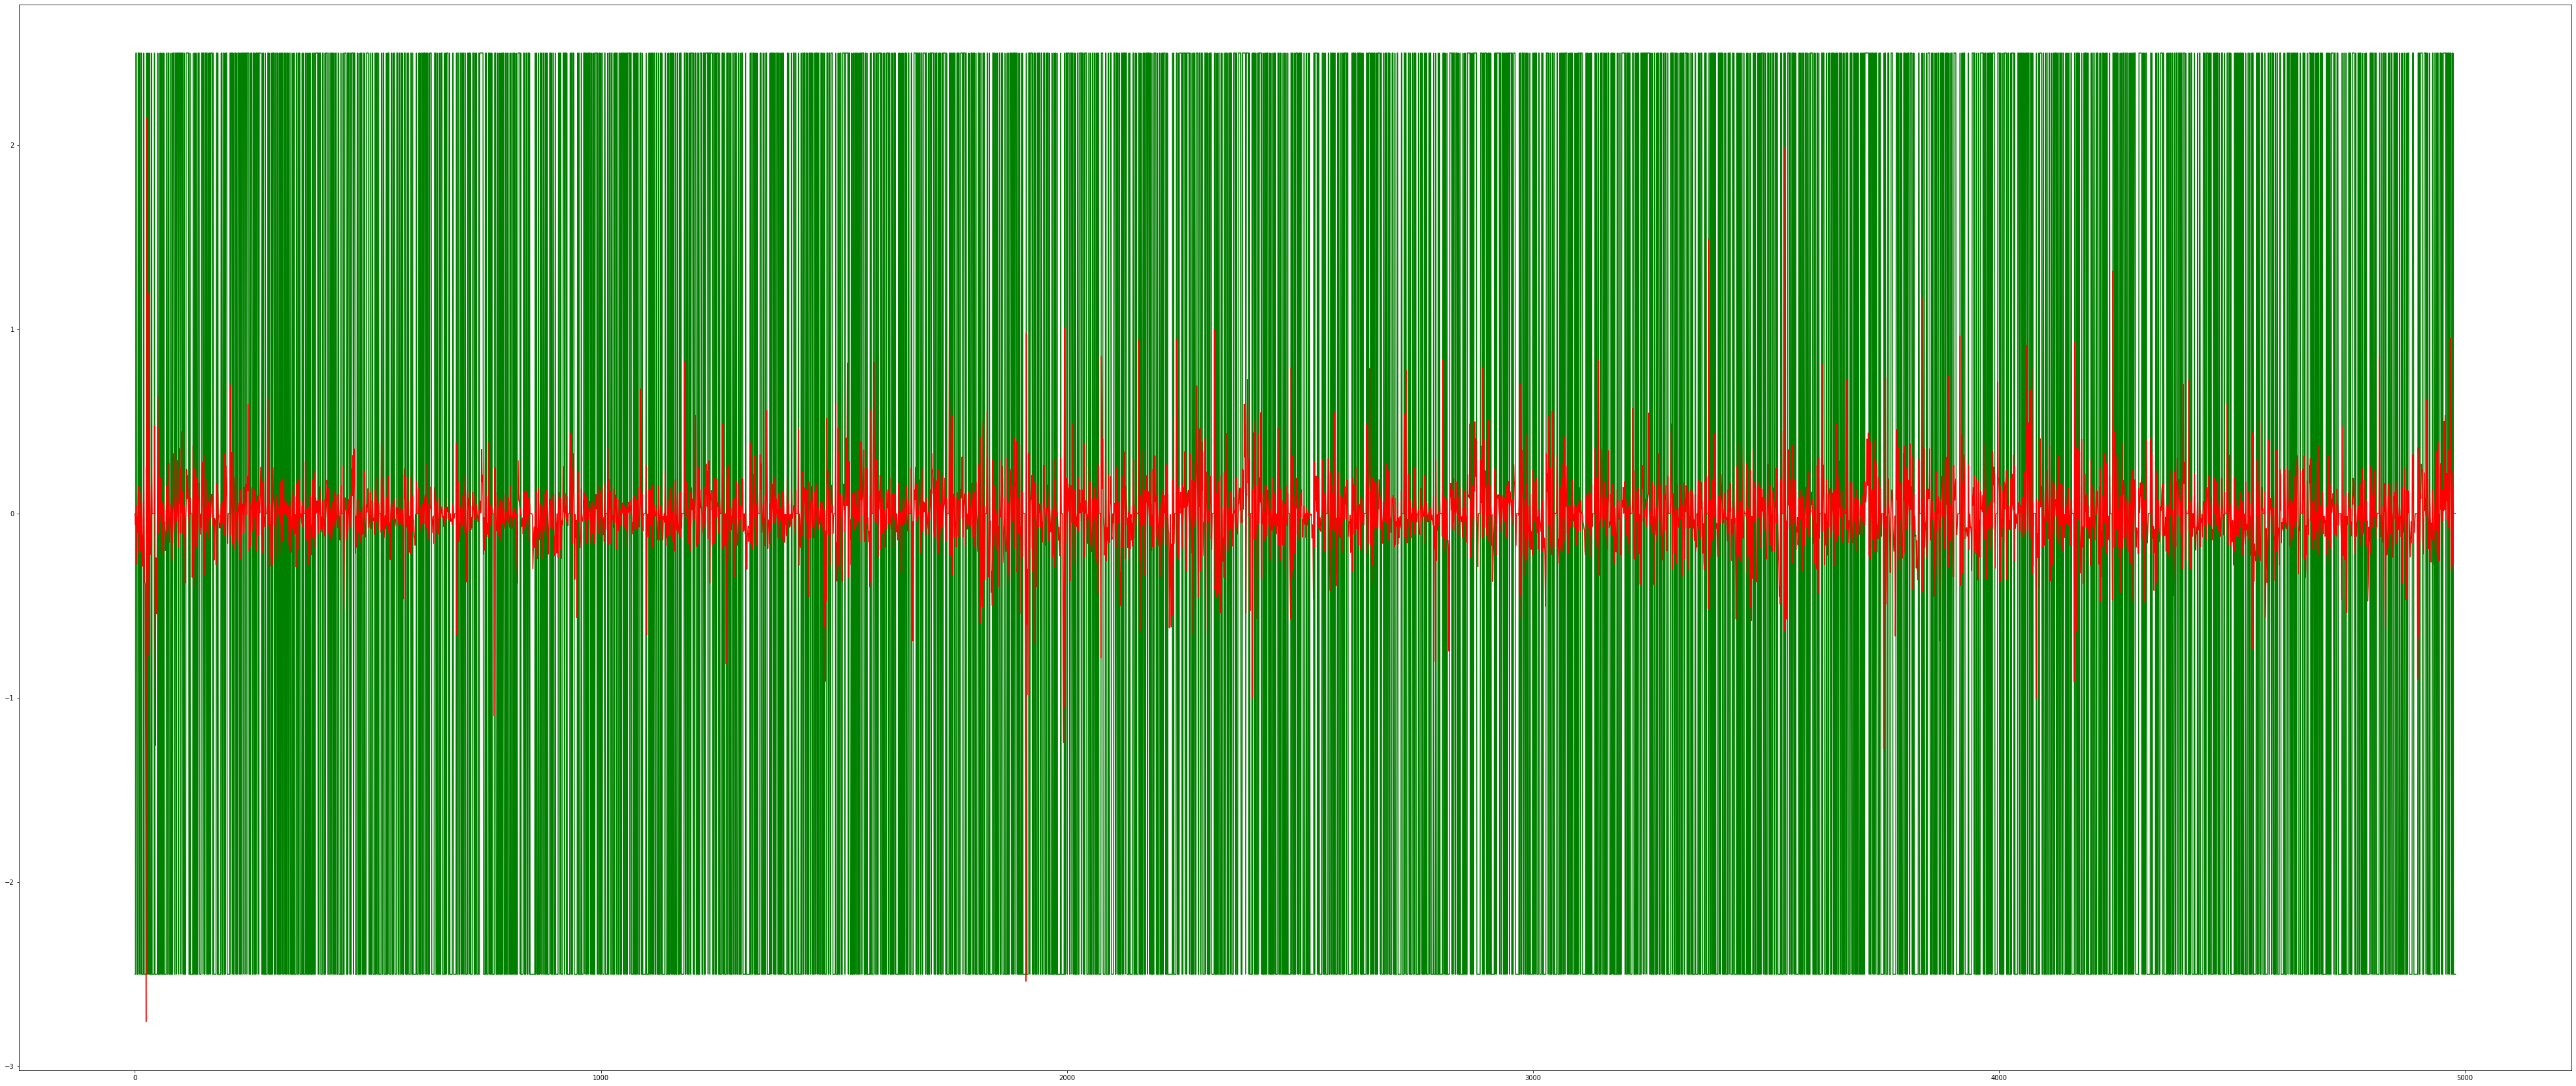

In [ ]:
plt.figure(figsize = (70,30))
plt.plot(df.sign, color = 'g') 
plt.plot(df['Returns_100'], color = 'r')


plt.show()

In [ ]:
df['positive_ret'] = df['Returns_100'][df['Returns_100'] > 0]
df['negative_ret'] = df['Returns_100'][df['Returns_100'] < 0]

In [ ]:
df.head()

,Unnamed: 0,Timestamp,open,high,low,close,volume,RSI,MOM,TR,ATR,SAR,Returns,sign,Returns_100,positive_ret,negative_ret
0,0,21-12-2020 12:35,2009.65,2010.00,2004.50,2007.90,173550.0,NaN,NaN,NaN,NaN,NaN,0.000000,-2.5,0.000000,NaN,NaN
1,1,21-12-2020 12:40,2007.90,2009.00,2005.80,2006.70,87120.0,NaN,NaN,3.20,NaN,2004.50,-0.000598,-2.5,-0.059764,NaN,-0.059764
2,2,21-12-2020 12:45,2005.65,2007.80,2003.15,2007.05,117939.0,NaN,NaN,4.65,NaN,2009.00,0.000174,2.5,0.017442,0.017442,NaN
3,3,21-12-2020 12:50,2007.45,2008.95,2006.95,2007.90,76782.0,NaN,NaN,2.00,NaN,2009.00,0.000424,2.5,0.042351,0.042351,NaN
4,4,21-12-2020 12:55,2008.00,2008.00,2001.60,2002.40,154965.0,NaN,NaN,6.40,NaN,2008.95,-0.002739,-2.5,-0.273918,NaN,-0.273918


In [ ]:
df[['positive_ret','negative_ret']].describe()

,positive_ret,negative_ret
count,2243.000000,2398.000000
mean,0.139294,-0.128360
std,0.163757,0.155509
min,0.002251,-2.757560
25%,0.041376,-0.165132
50%,0.094034,-0.086863
75%,0.174028,-0.039495
max,2.145267,-0.002283


In [ ]:
df.fillna(0, inplace=True)

LSTM    Returns predict 

classification model - probability - +ve or -ve - Quantile 

In [ ]:
data = df[['Returns_100', 'volume', 'RSI', 'MOM', 'TR', 'ATR', 'SAR']]

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(data)

sc_predict = StandardScaler()
sc_predict.fit_transform(data.iloc[:, 0:1])

array([[-0.00462586],
       [-0.30204939],
       [ 0.08217455],
       ...,
       [-0.00462586],
       [-0.00462586],
       [-0.00462586]])

In [ ]:
X = df[['volume', 'RSI', 'MOM', 'TR', 'ATR', 'SAR']]
y = df['Returns_100']

In [ ]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:data.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (4832, 90, 6).
y_train shape == (4832, 1).


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [ ]:
model = Sequential()

model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, data.shape[1]-1)))

model.add(LSTM(units=10, return_sequences=False))

model.add(Dropout(0.25))

model.add(Dense(units=1, activation='linear'))

model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 90, 64)            18176     
                                                                 
 lstm_3 (LSTM)               (None, 10)                3000      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 21,187
Trainable params: 21,187
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 0.9222
Epoch 00001: val_loss improved from inf to 0.97509, saving model to weights.h5
16/16 [==============================] - 7s 263ms/step - loss: 0.9222 - val_loss: 0.9751 - lr: 0.0100
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 0.9093
Epoch 00002: val_loss did not improve from 0.97509
16/16 [==============================] - 3s 210ms/step - loss: 0.9093 - val_loss: 0.9768 - lr: 0.0100
Epoch 3/30
16/16 [==============================] - ETA: 0s - loss: 0.9018
Epoch 00003: val_loss did not improve from 0.97509
16/16 [==============================] - 3s 205ms/step - loss: 0.9018 - val_loss: 0.9766 - lr: 0.0100
Epoch 4/30
16/16 [==============================] - ETA: 0s - loss: 0.8999
Epoch 00004: val_loss did not improve from 0.97509
16/16 [==============================] - 3s 209ms/step - loss: 0.8999 - val_loss: 0.9759 - lr: 0.0100
Epoch 5/30
16/16 [==============================] - ETA: 0s 

EarlyStopping - Stop training when a monitored metric has stopped improving.
monitor - quantity to be monitored.

min_delta - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.

patience - number of epochs with no improvement after which training will be stopped.

ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving.

factor - factor by which the learning rate will be reduced. new_lr = lr * factor.